In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.cluster import KMeans
import os

# Set matplotlib configuration
rcParams['figure.figsize'] = (20, 12)
%matplotlib inline

print("✅ OpenCV version:", cv2.__version__)
print("✅ NumPy version:", np.__version__)
print("\n🎯 Ready to detect potholes with THRESHOLDING methods!")

✅ OpenCV version: 4.11.0
✅ NumPy version: 1.26.4

🎯 Ready to detect potholes with THRESHOLDING methods!


---
## 🛠️ Helper Functions

In [2]:
def display_images(images, titles, cmap='gray', figsize=(20, 10)):
    """
    Display multiple images side-by-side
    """
    n = len(images)
    fig, axes = plt.subplots(1, n, figsize=figsize)
    
    if n == 1:
        axes = [axes]
    
    for i, (img, title) in enumerate(zip(images, titles)):
        if len(img.shape) == 3:  # Color image
            axes[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        else:  # Grayscale
            axes[i].imshow(img, cmap=cmap)
        
        axes[i].set_title(title, fontsize=14, fontweight='bold', pad=10)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

def calculate_contour_features(contour, image_gray):
    """
    Calculate features for filtering
    """
    area = cv2.contourArea(contour)
    x, y, w, h = cv2.boundingRect(contour)
    aspect_ratio = float(w) / h if h > 0 else 0
    
    # Extent
    rect_area = w * h
    extent = float(area) / rect_area if rect_area > 0 else 0
    
    # Solidity
    hull = cv2.convexHull(contour)
    hull_area = cv2.contourArea(hull)
    solidity = float(area) / hull_area if hull_area > 0 else 0
    
    # Mean intensity
    mask = np.zeros(image_gray.shape, dtype=np.uint8)
    cv2.drawContours(mask, [contour], -1, 255, -1)
    mean_intensity = cv2.mean(image_gray, mask=mask)[0]
    
    return {
        'area': area,
        'bbox': (x, y, w, h),
        'aspect_ratio': aspect_ratio,
        'extent': extent,
        'solidity': solidity,
        'mean_intensity': mean_intensity
    }

def filter_contours(contours, image_gray, 
                   min_area=500, max_area=50000,
                   min_aspect=0.3, max_aspect=3.0,
                   min_extent=0.15, max_extent=0.85,
                   min_solidity=0.3, max_solidity=0.95,
                   max_intensity=120):
    """
    Filter contours based on multiple criteria
    """
    valid_potholes = []
    
    for contour in contours:
        features = calculate_contour_features(contour, image_gray)
        
        # Filter by area
        if not (min_area < features['area'] < max_area):
            continue
        
        # Filter by aspect ratio
        if not (min_aspect < features['aspect_ratio'] < max_aspect):
            continue
        
        # Filter by extent (irregularity)
        if not (min_extent < features['extent'] < max_extent):
            continue
        
        # Filter by solidity (concavity)
        if not (min_solidity < features['solidity'] < max_solidity):
            continue
        
        # Filter by intensity (darkness)
        if features['mean_intensity'] > max_intensity:
            continue
        
        valid_potholes.append({
            'contour': contour,
            'features': features
        })
    
    return valid_potholes

def draw_results(image, potholes):
    """
    Draw bounding boxes on detected potholes
    """
    result = image.copy()
    
    for pothole in potholes:
        x, y, w, h = pothole['features']['bbox']
        
        # Draw bounding box
        cv2.rectangle(result, (x, y), (x+w, y+h), (0, 255, 0), 3)
        
        # Draw label
        label = f"Pothole {w}x{h}"
        cv2.putText(result, label, (x, y-10), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    
    return result

print("✅ Helper functions loaded!")

✅ Helper functions loaded!


---
## 🔧 METHOD 2: Adaptive Thresholding

**Konsep:**
- Local threshold (berbeda untuk setiap region)
- Threshold = mean/gaussian of neighborhood - C
- Robust terhadap uneven lighting

**Kelebihan:**
- ✅ Bagus untuk variasi pencahayaan
- ✅ Local adaptation
- ✅ Handle shadows better

**Pipeline:**
1. Grayscale → Blur → **Adaptive Threshold**
2. Morphological Operations
3. Contour Detection + Filtering

In [4]:
class PotholeDetectorAdaptive:
    """
    Pothole Detection using Adaptive Thresholding
    """
    
    def __init__(self, target_size=(640, 480), blur_kernel=7, 
                 block_size=51, C=10):
        self.target_size = target_size
        self.blur_kernel = blur_kernel
        self.block_size = block_size  # Must be odd
        self.C = C  # Constant subtracted from mean
    
    def preprocess(self, image):
        """Preprocessing"""
        img_resized = cv2.resize(image, self.target_size)
        img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
        img_blurred = cv2.GaussianBlur(img_gray, (self.blur_kernel, self.blur_kernel), 0)
        return img_resized, img_gray, img_blurred
    
    def apply_adaptive_threshold(self, image):
        """Apply Adaptive Thresholding"""
        # Adaptive threshold with MEAN method
        binary = cv2.adaptiveThreshold(
            image, 255,
            cv2.ADAPTIVE_THRESH_MEAN_C,
            cv2.THRESH_BINARY_INV,
            self.block_size,
            self.C
        )
        return binary
    
    def morphological_operations(self, binary):
        """Clean up binary image"""
        kernel_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
        opened = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel_open, iterations=2)
        
        kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))
        closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel_close, iterations=2)
        
        return opened, closed
    
    def detect(self, image):
        """Main detection pipeline"""
        img_resized, img_gray, img_blurred = self.preprocess(image)
        
        # Adaptive Thresholding
        binary = self.apply_adaptive_threshold(img_blurred)
        
        # Morphological Operations
        opened, closed = self.morphological_operations(binary)
        
        # Find Contours
        contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Filter Contours
        valid_potholes = filter_contours(contours, img_gray,
                                        min_area=500, max_area=50000,
                                        max_intensity=120)
        
        result = draw_results(img_resized, valid_potholes)
        
        return {
            'original': image,
            'resized': img_resized,
            'gray': img_gray,
            'blurred': img_blurred,
            'binary_adaptive': binary,
            'opened': opened,
            'closed': closed,
            'result': result,
            'potholes': valid_potholes,
            'count': len(valid_potholes)
        }

print("✅ PotholeDetectorAdaptive class ready!")

✅ PotholeDetectorAdaptive class ready!


---
## 🧪 TESTING: Load Images

✅ img-733.jpg loaded: (265, 416, 3)
✅ img-592.jpg loaded: (300, 336, 3)


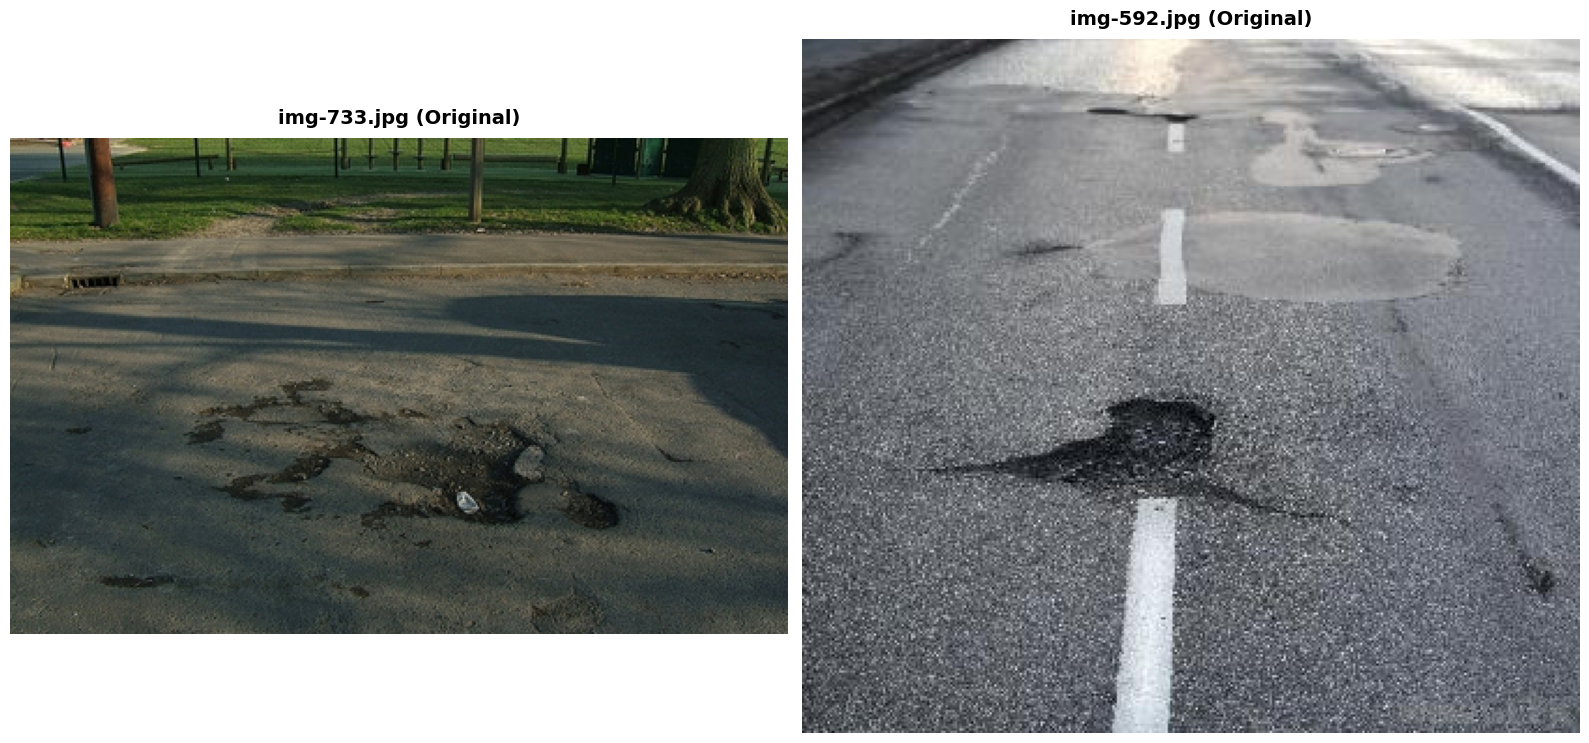

In [6]:
# Load test images
img1_path = 'dataset/img-733.jpg'
img2_path = 'dataset/img-592.jpg'

img1 = cv2.imread(img1_path)
img2 = cv2.imread(img2_path)

if img1 is None or img2 is None:
    print("❌ Error loading images!")
else:
    print(f"✅ img-733.jpg loaded: {img1.shape}")
    print(f"✅ img-592.jpg loaded: {img2.shape}")
    
    # Display originals
    display_images([img1, img2], 
                   ['img-733.jpg (Original)', 'img-592.jpg (Original)'],
                   figsize=(16, 8))

---
## 🧪 TEST METHOD 2: Adaptive Thresholding

In [10]:
print("="*80)
print("🔥 METHOD 2: ADAPTIVE THRESHOLDING")
print("="*80)

# Initialize detector
detector_adaptive = PotholeDetectorAdaptive(blur_kernel=7, block_size=51, C=10)

# Test on img-733
print("\n🚗 Testing on img-733.jpg...")
results1_adaptive = detector_adaptive.detect(img1)
print(f"✅ Found {results1_adaptive['count']} pothole(s)")

# Test on img-592
print("\n🚗 Testing on img-592.jpg...")
results2_adaptive = detector_adaptive.detect(img2)
print(f"✅ Found {results2_adaptive['count']} pothole(s)")

print("\n" + "="*80)

🔥 METHOD 2: ADAPTIVE THRESHOLDING

🚗 Testing on img-733.jpg...
✅ Found 9 pothole(s)

🚗 Testing on img-592.jpg...
✅ Found 1 pothole(s)



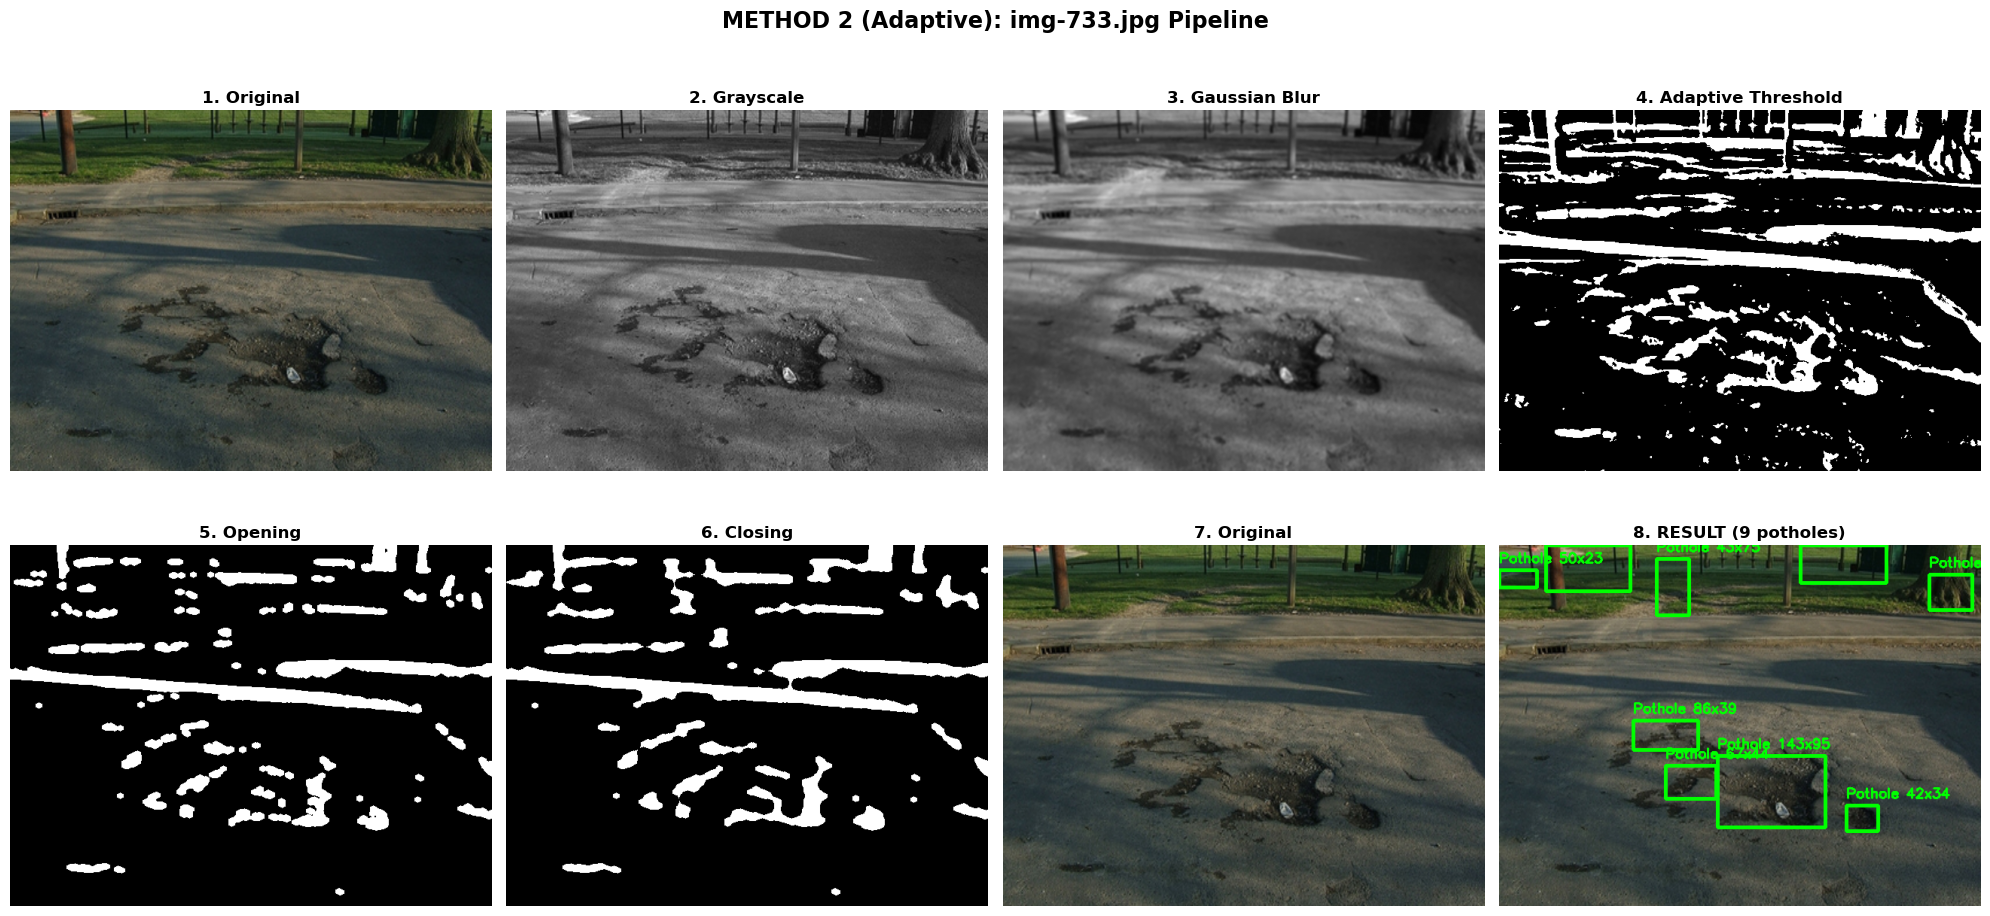

In [11]:
# Visualize img-733 pipeline
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('METHOD 2 (Adaptive): img-733.jpg Pipeline', fontsize=16, fontweight='bold')

axes[0, 0].imshow(cv2.cvtColor(results1_adaptive['resized'], cv2.COLOR_BGR2RGB))
axes[0, 0].set_title('1. Original', fontweight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(results1_adaptive['gray'], cmap='gray')
axes[0, 1].set_title('2. Grayscale', fontweight='bold')
axes[0, 1].axis('off')

axes[0, 2].imshow(results1_adaptive['blurred'], cmap='gray')
axes[0, 2].set_title('3. Gaussian Blur', fontweight='bold')
axes[0, 2].axis('off')

axes[0, 3].imshow(results1_adaptive['binary_adaptive'], cmap='gray')
axes[0, 3].set_title('4. Adaptive Threshold', fontweight='bold')
axes[0, 3].axis('off')

axes[1, 0].imshow(results1_adaptive['opened'], cmap='gray')
axes[1, 0].set_title('5. Opening', fontweight='bold')
axes[1, 0].axis('off')

axes[1, 1].imshow(results1_adaptive['closed'], cmap='gray')
axes[1, 1].set_title('6. Closing', fontweight='bold')
axes[1, 1].axis('off')

axes[1, 2].imshow(cv2.cvtColor(results1_adaptive['resized'], cv2.COLOR_BGR2RGB))
axes[1, 2].set_title('7. Original', fontweight='bold')
axes[1, 2].axis('off')

axes[1, 3].imshow(cv2.cvtColor(results1_adaptive['result'], cv2.COLOR_BGR2RGB))
axes[1, 3].set_title(f'8. RESULT ({results1_adaptive["count"]} potholes)', fontweight='bold')
axes[1, 3].axis('off')

plt.tight_layout()
plt.show()

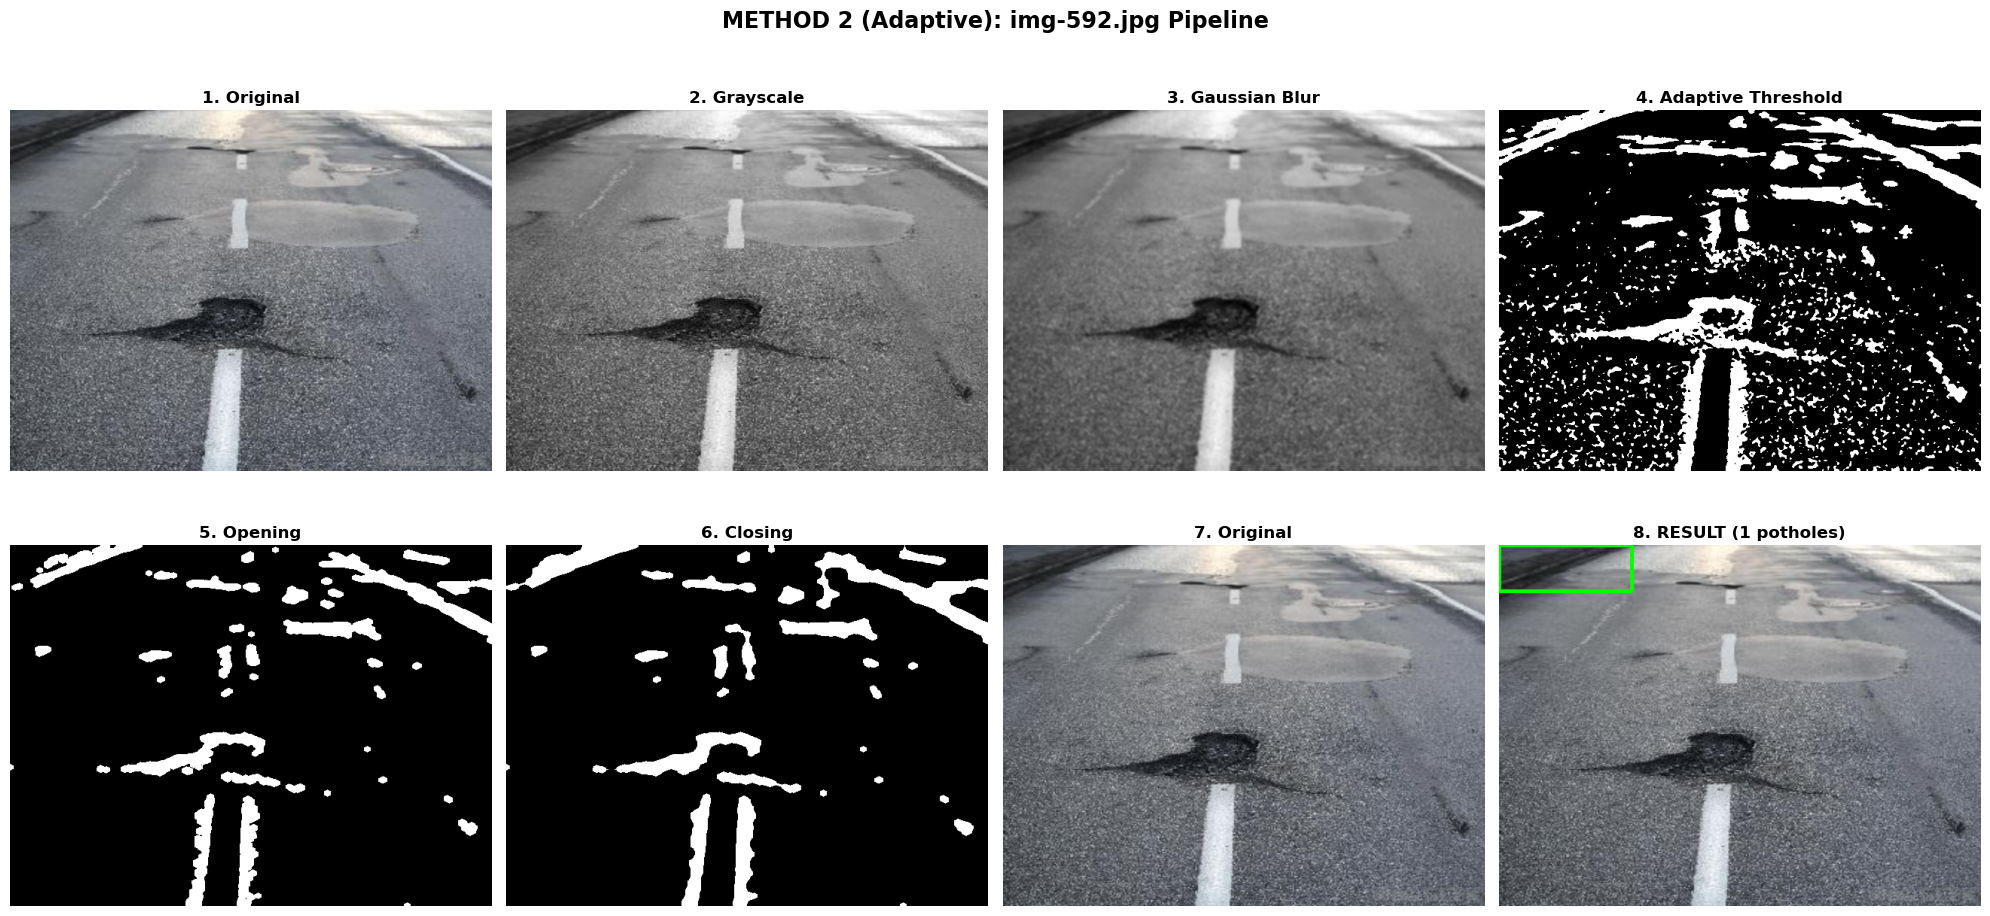

In [12]:
# Visualize img-592 pipeline
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('METHOD 2 (Adaptive): img-592.jpg Pipeline', fontsize=16, fontweight='bold')

axes[0, 0].imshow(cv2.cvtColor(results2_adaptive['resized'], cv2.COLOR_BGR2RGB))
axes[0, 0].set_title('1. Original', fontweight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(results2_adaptive['gray'], cmap='gray')
axes[0, 1].set_title('2. Grayscale', fontweight='bold')
axes[0, 1].axis('off')

axes[0, 2].imshow(results2_adaptive['blurred'], cmap='gray')
axes[0, 2].set_title('3. Gaussian Blur', fontweight='bold')
axes[0, 2].axis('off')

axes[0, 3].imshow(results2_adaptive['binary_adaptive'], cmap='gray')
axes[0, 3].set_title('4. Adaptive Threshold', fontweight='bold')
axes[0, 3].axis('off')

axes[1, 0].imshow(results2_adaptive['opened'], cmap='gray')
axes[1, 0].set_title('5. Opening', fontweight='bold')
axes[1, 0].axis('off')

axes[1, 1].imshow(results2_adaptive['closed'], cmap='gray')
axes[1, 1].set_title('6. Closing', fontweight='bold')
axes[1, 1].axis('off')

axes[1, 2].imshow(cv2.cvtColor(results2_adaptive['resized'], cv2.COLOR_BGR2RGB))
axes[1, 2].set_title('7. Original', fontweight='bold')
axes[1, 2].axis('off')

axes[1, 3].imshow(cv2.cvtColor(results2_adaptive['result'], cv2.COLOR_BGR2RGB))
axes[1, 3].set_title(f'8. RESULT ({results2_adaptive["count"]} potholes)', fontweight='bold')
axes[1, 3].axis('off')

plt.tight_layout()
plt.show()